# Predict Credit Card Consumption of Customer For a Leading Bank

#### Import the packages

In [842]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from scipy.stats import norm, skew
%matplotlib inline

## Business Objective

- a) Customer Demographics
- b) Customer Behaviorial data (information on liabilities, assets and history of transactions with bank of each customer)Data has been provided for a particular set of customer's credit card spend in the previous 3 months (Apr, May & June) and their expected average spend in the coming 3 Months (Jul, Aug, Sep)
- c) Credit Consumption

In [843]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# from sklearn.linear_model import LinearRegression
# sklearn - scikit learn

### UDFs

In [844]:
def continuous_var_summary( x ):
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max']) 

In [845]:
# Create Data audit Report for categorical variables
def categorical_var_summary( x ):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100 / x.count(), 2)], 
                     
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [846]:
# Missing value imputation for continuous variables
def missing_imputation( x, stats = 'mean' ):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x

In [847]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [848]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

### Import data

In [849]:
#F:\AnalytixLabs\Archis_ML\ML Assignments\11_ML_Predicting Credit Consumption
file_path = 'F:/AnalytixLabs/Archis_ML/ML_Assignments/11_ML_Predicting Credit Consumption/'


In [850]:
CreditConsumptionData = pd.read_excel(file_path + 'CreditConsumptionData.xlsx')

In [851]:
CustomerBehaviorData = pd.read_excel(file_path + 'CustomerBehaviorData.xlsx')

In [852]:
CustomerDemographics = pd.read_excel(file_path + 'CustomerDemographics.xlsx')

### Data Inspection

In [853]:
CreditConsumptionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       20000 non-null  int64  
 1   cc_cons  15000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 312.6 KB


In [854]:
CustomerBehaviorData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     20000 non-null  int64  
 1   cc_cons_apr            20000 non-null  float64
 2   dc_cons_apr            20000 non-null  float64
 3   cc_cons_may            19999 non-null  float64
 4   dc_cons_may            20000 non-null  float64
 5   cc_cons_jun            20000 non-null  float64
 6   dc_cons_jun            19999 non-null  float64
 7   cc_count_apr           19999 non-null  float64
 8   cc_count_may           20000 non-null  int64  
 9   cc_count_jun           20000 non-null  int64  
 10  dc_count_apr           20000 non-null  int64  
 11  dc_count_may           20000 non-null  int64  
 12  dc_count_jun           20000 non-null  int64  
 13  card_lim               20000 non-null  int64  
 14  personal_loan_active   20000 non-null  int64  
 15  ve

In [855]:
CustomerDemographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   account_type                  19999 non-null  object 
 2   gender                        19999 non-null  object 
 3   age                           20000 non-null  int64  
 4   Income                        19999 non-null  object 
 5   Emp_Tenure_Years              20000 non-null  float64
 6   Tenure_with_Bank              20000 non-null  int64  
 7   region_code                   19999 non-null  float64
 8   NetBanking_Flag               20000 non-null  int64  
 9   Avg_days_between_transaction  19997 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 1.5+ MB


In [856]:
df1 = pd.merge(CreditConsumptionData,CustomerBehaviorData)
df = pd.merge(df1,CustomerDemographics)

In [857]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   cc_cons                       15000 non-null  float64
 2   cc_cons_apr                   20000 non-null  float64
 3   dc_cons_apr                   20000 non-null  float64
 4   cc_cons_may                   19999 non-null  float64
 5   dc_cons_may                   20000 non-null  float64
 6   cc_cons_jun                   20000 non-null  float64
 7   dc_cons_jun                   19999 non-null  float64
 8   cc_count_apr                  19999 non-null  float64
 9   cc_count_may                  20000 non-null  int64  
 10  cc_count_jun                  20000 non-null  int64  
 11  dc_count_apr                  20000 non-null  int64  
 12  dc_count_may                  20000 non-null  int64  
 13  d

In [858]:
df.columns

Index(['ID', 'cc_cons', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may',
       'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr',
       'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may',
       'dc_count_jun', 'card_lim', 'personal_loan_active',
       'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed',
       'investment_1', 'investment_2', 'investment_3', 'investment_4',
       'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr',
       'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may',
       'credit_amount_may', 'credit_count_may', 'debit_count_may',
       'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun',
       'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun',
       'loan_enq', 'emi_active', 'account_type', 'gender', 'age', 'Income',
       'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code',
       'NetBanking_Flag', 'Avg_days_between_transaction'],
      dtype='object')

In [859]:
df.shape

(20000, 49)

In [860]:
#cardinality
df.nunique()

ID                              20000
cc_cons                         12260
cc_cons_apr                      8459
dc_cons_apr                      3861
cc_cons_may                      8504
dc_cons_may                      4053
cc_cons_jun                      7347
dc_cons_jun                      3019
cc_count_apr                       50
cc_count_may                       58
cc_count_jun                       67
dc_count_apr                       41
dc_count_may                       39
dc_count_jun                       54
card_lim                          308
personal_loan_active                1
vehicle_loan_active                 1
personal_loan_closed                1
vehicle_loan_closed                 1
investment_1                      691
investment_2                      532
investment_3                      246
investment_4                      115
debit_amount_apr                 8724
credit_amount_apr                8153
debit_count_apr                    63
credit_count

In [861]:
# in case we have huge data and we dont want to make the copy of the original data 
# we generally go with the option of getting column/variable names for obejat and numeric type

numeric_columns = df.select_dtypes(include = ['float64', 'int64']).columns
object_columns = df.select_dtypes(include = ['object']).columns

In [862]:
df[object_columns].head(2)

,loan_enq,account_type,gender,Income
0,Y,current,M,MEDIUM
1,Y,current,M,HIGH


In [863]:
numeric_columns

Index(['ID', 'cc_cons', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may',
       'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr',
       'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may',
       'dc_count_jun', 'card_lim', 'personal_loan_active',
       'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed',
       'investment_1', 'investment_2', 'investment_3', 'investment_4',
       'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr',
       'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may',
       'credit_amount_may', 'credit_count_may', 'debit_count_may',
       'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun',
       'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun',
       'emi_active', 'age', 'Emp_Tenure_Years', 'Tenure_with_Bank',
       'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction'],
      dtype='object')

In [864]:
# Separate continous and categorical values
df_conti_vars = df.select_dtypes(include = ['float64', 'int64'])
df_cat_vars = df.select_dtypes(include = ['object'])

In [865]:
# alternate of .describe() for continuous variables
df_conti_vars.apply( continuous_var_summary ).round(1)

# cars_conti_vars.apply( lambda x: continuous_var_summary(x)).round(1)

,ID,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,...,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction
dtype,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,...,int64,int64,float64,float64,int64,float64,int64,float64,int64,float64
cardinality,20000,12260,8459,3861,8504,4053,7347,3019,50,58,...,39,66,5833,5940,43,270,10,210,2,19
n_tot,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,...,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
n,20000,15000,20000,20000,19999,20000,20000,19999,19999,20000,...,20000,20000,20000,19999,20000,20000,20000,19999,20000,19997
nmiss,0,5000,0,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,3
perc_miss,0.0,25.0,0.0,0.0,0.005,0.0,0.0,0.005,0.005,0.0,...,0.0,0.0,0.0,0.005,0.0,0.0,0.0,0.005,0.0,0.015
sum,199990000,827365948.0,357139818.44,162609068.27,323751105.97,154048543.82,242716120.41,142187057.12,832191.0,671382,...,398109,890582,1056996951.42,307961976.6,953446,304345.0,109921,11978588.0,14360,220862.0
mean,9999.5,55157.729867,17856.990922,8130.453414,16188.364717,7702.427191,12135.806021,7109.708341,41.611631,33.5691,...,19.90545,44.5291,52849.847571,15398.868773,47.6723,15.21725,5.49605,598.959348,0.718,11.044757
std,5773.647028,97670.972252,25158.878234,14572.188829,26510.681596,17892.7318,18790.984789,13313.935609,97.835475,50.316925,...,27.055323,35.080453,134317.525107,120254.075769,30.359771,20.481455,2.870452,220.10523,0.449985,5.480552
var,33335000.0,9539618820.721489,632969153.98808,212348687.260089,702816238.690255,320149851.281652,353101109.329598,177260881.388224,9571.780105,2531.792915,...,731.99051,1230.638185,18041197550.945351,14461042739.004253,921.715698,419.489979,8.239496,48446.312129,0.202486,30.036454


In [866]:
# alternate of .describe() for categorical variables
df_cat_vars.apply(categorical_var_summary)

,loan_enq,account_type,gender,Income
N,19998,19999,19999,19999
NMISS,2,1,1,1
MODE,Y,current,M,MEDIUM
FREQ,19998,16925,17287,12774
PERCENT,100.0,84.63,86.44,63.87


###  Converting Categorical Columns to Numerical columns

In [867]:
df.loan_enq = pd.Categorical(df.loan_enq).codes
df.account_type = pd.Categorical(df.account_type).codes
df.gender = pd.Categorical(df.gender).codes
df.Income = pd.Categorical(df.Income).codes

In [868]:
df.head(3)

,ID,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,...,emi_active,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction
0,12554,20014.0,24893.00,378.0,10288.0,29664.00,16291.40,11432.0,2.0,26,...,1674.09,0,1,35,2,15.0,1,708.0,0,17.0
1,17645,10173.0,18941.62,966.0,20672.0,287.00,4217.00,885.0,1.0,7,...,13043.34,0,1,35,0,15.0,6,123.0,0,14.0
2,7604,16095.0,5678.87,2724.0,1964.5,3933.11,23956.25,5168.0,43.0,32,...,25375.27,0,1,55,2,24.5,1,802.0,1,3.0


#### Missing Value Treatment

In [869]:
df_conti_vars.isna().sum() * 100 / df_conti_vars.isna().count()

ID                               0.000
cc_cons                         25.000
cc_cons_apr                      0.000
dc_cons_apr                      0.000
cc_cons_may                      0.005
dc_cons_may                      0.000
cc_cons_jun                      0.000
dc_cons_jun                      0.005
cc_count_apr                     0.005
cc_count_may                     0.000
cc_count_jun                     0.000
dc_count_apr                     0.000
dc_count_may                     0.000
dc_count_jun                     0.000
card_lim                         0.000
personal_loan_active             0.000
vehicle_loan_active              0.000
personal_loan_closed             0.005
vehicle_loan_closed              0.000
investment_1                     0.000
investment_2                     0.000
investment_3                     0.010
investment_4                     0.000
debit_amount_apr                 0.000
credit_amount_apr                0.000
debit_count_apr          

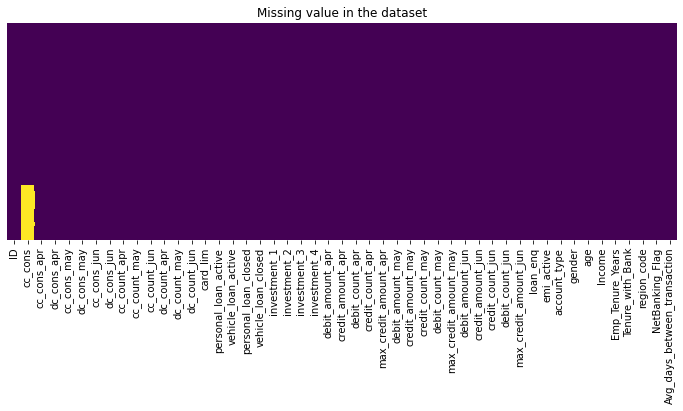

In [870]:
plt.figure(figsize=(12,4))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

In [871]:
# Extracting the cc_cons columns with missing values, Two separate datasets

train = df[~df.cc_cons.isna()]
test =df[df.cc_cons.isna()]

### Training and Test Sets

In [872]:


y_test = df[df['cc_cons'].isnull()]['cc_cons']
y_train = df[~df['cc_cons'].isnull()]['cc_cons']


print(y_test)
print(y_train)

x_train = df[~df['cc_cons'].isnull()]
x_test = df[df['cc_cons'].isnull()]

print(x_train)
print(x_test)


15000   NaN
15001   NaN
15002   NaN
15003   NaN
15004   NaN
         ..
19995   NaN
19996   NaN
19997   NaN
19998   NaN
19999   NaN
Name: cc_cons, Length: 5000, dtype: float64
0         20014.0
1         10173.0
2         16095.0
3          7707.0
4         96408.0
           ...   
14995      4263.0
14996     11019.0
14997    404227.0
14998     28813.0
14999     16252.0
Name: cc_cons, Length: 15000, dtype: float64
          ID   cc_cons  cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  \
0      12554   20014.0     24893.00       378.00     10288.00     29664.00   
1      17645   10173.0     18941.62       966.00     20672.00       287.00   
2       7604   16095.0      5678.87      2724.00      1964.50      3933.11   
3       1590    7707.0     30489.50      1236.00     12609.88      9138.14   
4      16556   96408.0      7441.40      6906.04      4364.00      1939.00   
...      ...       ...          ...          ...          ...          ...   
14995   6995    4263.0     10443.76

### Missing Data Imputation

In [873]:
#missing data - x_train
total = x_train.isnull().sum().sort_values(ascending=False)
percent = (x_train.isnull().sum()/x_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
investment_3,2,0.000133
Avg_days_between_transaction,1,0.000067
cc_count_apr,1,0.000067
personal_loan_closed,1,0.000067
emi_active,1,0.000067
debit_count_apr,1,0.000067
Income,0,0.000000
age,0,0.000000
debit_amount_may,0,0.000000
credit_amount_may,0,0.000000


In [874]:
x_train.isna().sum().sum()

7

In [875]:
#missing data - x_train
total = x_test.isnull().sum().sort_values(ascending=False)
percent = (x_test.isnull().sum()/x_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
cc_cons,5000,1.0000
Avg_days_between_transaction,2,0.0004
region_code,1,0.0002
cc_cons_may,1,0.0002
dc_cons_jun,1,0.0002
debit_count_jun,0,0.0000
debit_amount_may,0,0.0000
credit_amount_may,0,0.0000
credit_count_may,0,0.0000
debit_count_may,0,0.0000


In [876]:
x_test.isna().sum().sum()

5005

In [877]:
#missing data - y_train
y_train.isna().sum()

0

### Linear Regression

In [878]:
x_train.shape

(15000, 49)

###Missing Value Imputation

In [879]:
x_train = x_train.apply(missing_imputation)

In [880]:
x_train.isna().sum().sum()

0

In [881]:
y_train.shape

(15000,)

In [882]:
####Cleaning Datasetes

In [883]:
x_train = x_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_train = y_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
x_test = x_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_test = y_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [884]:
x_test.shape

(5000, 49)

In [885]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [886]:
# print the intercept
print(model.intercept_)

-5.020410753786564e-10


In [887]:
# print the coefficeints
print(model.coef_)

[ 1.84069104e-15  1.00000000e+00  6.77929934e-15 -6.93889390e-16
  7.71605002e-15  2.50494070e-15 -1.77635684e-15  4.21884749e-15
 -5.86392046e-13 -1.32428722e-13  7.32841983e-13 -2.48866483e-12
  3.09634787e-12  3.69666110e-13  4.44089210e-16  1.17961196e-16
 -8.32667268e-17 -2.77555756e-17  0.00000000e+00 -1.66533454e-16
 -1.66533454e-16 -6.66133815e-16  7.11236625e-16  6.10622664e-16
 -4.16333634e-17 -5.80370035e-15 -6.87581248e-14  0.00000000e+00
  3.33066907e-16  0.00000000e+00  1.93831089e-14 -3.85191282e-15
  2.49800181e-16  6.59194921e-16  3.95516953e-16  2.12770272e-15
 -3.51494279e-15  5.13478149e-16 -3.11703377e-11  6.10622664e-16
  1.19880341e-13  6.04983747e-13  2.58609662e-15  5.44227713e-13
 -3.90908416e-15  6.64130488e-14 -1.92524490e-15  3.83755932e-13
 -1.90360109e-15]


### **Predictions from our Model **

In [888]:
from sklearn import metrics

In [889]:
predictions = model.predict(x_test)
predictions= predictions.reshape(-1,1)

In [890]:
from sklearn import metrics

In [891]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 2.9660894787039316e-10
MSE: 3.835948460907551e-19
RMSE: 6.193503419638639e-10
